In [140]:
import os, torch, torch.nn as nn, torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import time
import torchvision.datasets as datasets
if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")


In [141]:
class VAE(nn.Module):
    def __init__(self, z=500):
        super().__init__()
        self.layer1 = nn.Linear(784,5000)
        self.mn = nn.Linear(5000,z) 
        self.log_variance = nn.Linear(5000,z)
        self.layer2 = nn.Linear(z,5000) 
        self.layer3 = nn.Linear(5000,784)
        
    def encode(self,x):
        h=F.relu(self.layer1(x.view(-1,784))); 
        return self.mn(h), self.log_variance(h)
   
    def decode(self,z): 
        return torch.sigmoid(self.layer3(F.relu(self.layer2(z))))
    def reparam(self,mn,log_variance): 
        return mn+torch.exp(0.5*log_variance)*torch.randn_like(mn)
    def forward(self,x):
        mn,log_variance=self.encode(x); z=self.reparam(mn,log_variance); return self.decode(z), mn, log_variance
        
def elbo(rec,x,mn,log_variance):
    bce=F.binary_cross_entropy(rec,x.view(-1,784),reduction="sum")
    kld=-0.5*torch.sum(1+log_variance-mn.pow(2)-log_variance.exp())
    return bce+kld

In [142]:

transform = transforms.ToTensor()
data = datasets.MNIST(root="data", train=True, download=True, transform=transform)

train_size = int(0.9 * len(data))
test_size = len(data) - train_size
train_data, test_data = random_split(data, [train_size, test_size])

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)
vae = VAE().to(DEVICE)
opt=torch.optim.Adam(vae.parameters(),1e-3)

vae1 = VAE(z=50).to(DEVICE)
opt1=torch.optim.Adam(vae.parameters(),1e-3)

vae2 = VAE(z=500).to(DEVICE)
opt2=torch.optim.Adam(vae2.parameters(),1e-3)

print(vae)

VAE(
  (layer1): Linear(in_features=784, out_features=5000, bias=True)
  (mn): Linear(in_features=5000, out_features=500, bias=True)
  (log_variance): Linear(in_features=5000, out_features=500, bias=True)
  (layer2): Linear(in_features=500, out_features=5000, bias=True)
  (layer3): Linear(in_features=5000, out_features=784, bias=True)
)


In [143]:
def train_vae(vae, train_loader, test_loader, opt, z_dim, epochs=2000, device=DEVICE, print_every=1):
    
    vae.to(device)
    graph_train, graph_test = [], []
    n_train = len(train_loader.dataset)
    n_test  = len(test_loader.dataset)

    for ep in range(1, epochs + 1):
        start = time.time()

        vae.train()
        total_train = 0.0
        for x, _ in train_loader:
            x = x.to(device)
            rec, mn, log_variance = vae(x)
            loss = elbo(rec, x, mn, log_variance)

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_train += loss.item()

        train_elbo_img = total_train / n_train
        graph_train.append(train_elbo_img)

        vae.eval()
        total_test = 0.0
        with torch.no_grad():
            for x, _ in test_loader:
                x = x.to(device)
                rec, mn, log_variance = vae(x)
                loss = elbo(rec, x, mn, log_variance)
                total_test += loss.item()

        test_elbo_img = total_test / n_test
        graph_test.append(test_elbo_img)

        elapsed = time.time() - start
        if ep % print_every == 0:
            print(f"Epoch {ep}/{epochs}  Train -ELBO/img {train_elbo_img:.2f}  "
                  f"Test -ELBO/img {test_elbo_img:.2f}  Time: {elapsed:.1f}s")

   
    save_path = f"vae_mnist_{z_dim}_{epochs}.pth"
    torch.save(vae.state_dict(), save_path)
    print(f"Model weights saved to {save_path}")


    plt.figure(figsize=(6,4))
    plt.plot(range(1, epochs + 1), graph_train, marker="o", label="Train")
    plt.plot(range(1, epochs + 1), graph_test,  marker="o", label="Test")
    plt.title("VAE training – -ELBO per image")
    plt.xlabel("Epoch"); plt.ylabel("-ELBO (nats / image)")
    plt.grid(alpha=.3); plt.legend()
    plt.tight_layout(); plt.show()

    #return graph_train, graph_test


Training of VAE with z 500 and epochs 100

Epoch 1/100  Train -ELBO/img 160.28  Test -ELBO/img 142.33  Time: 8.6s
Epoch 2/100  Train -ELBO/img 139.48  Test -ELBO/img 135.43  Time: 8.4s
Epoch 3/100  Train -ELBO/img 130.81  Test -ELBO/img 126.31  Time: 8.4s
Epoch 4/100  Train -ELBO/img 123.72  Test -ELBO/img 121.77  Time: 9.0s
Epoch 5/100  Train -ELBO/img 120.06  Test -ELBO/img 118.28  Time: 8.9s
Epoch 6/100  Train -ELBO/img 116.83  Test -ELBO/img 115.16  Time: 8.4s
Epoch 7/100  Train -ELBO/img 113.96  Test -ELBO/img 113.05  Time: 8.4s
Epoch 8/100  Train -ELBO/img 111.93  Test -ELBO/img 111.18  Time: 8.4s
Epoch 9/100  Train -ELBO/img 110.47  Test -ELBO/img 110.14  Time: 8.4s
Epoch 10/100  Train -ELBO/img 109.44  Test -ELBO/img 109.27  Time: 8.4s
Epoch 11/100  Train -ELBO/img 108.74  Test -ELBO/img 109.02  Time: 8.3s
Epoch 12/100  Train -ELBO/img 108.18  Test -ELBO/img 108.50  Time: 8.4s
Epoch 13/100  Train -ELBO/img 107.75  Test -ELBO/img 107.92  Time: 8.3s
Epoch 14/100  Train -ELBO/img 107.33  Test -ELBO/img 107.57  Time: 8.4s
E

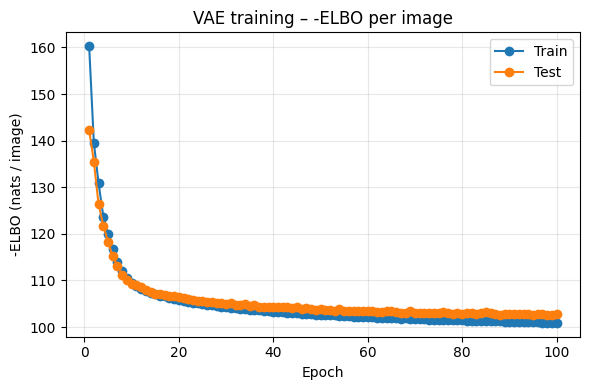

In [144]:
train_vae(vae, train_loader, test_loader, opt, 500, epochs=100, device=DEVICE, print_every=1)

Training of VAE with z 50 and epochs 100

Epoch 1/100  Train -ELBO/img 549.35  Test -ELBO/img 549.30  Time: 3.1s
Epoch 2/100  Train -ELBO/img 549.31  Test -ELBO/img 549.35  Time: 3.0s
Epoch 3/100  Train -ELBO/img 549.35  Test -ELBO/img 549.35  Time: 3.1s
Epoch 4/100  Train -ELBO/img 549.35  Test -ELBO/img 549.32  Time: 3.1s
Epoch 5/100  Train -ELBO/img 549.34  Test -ELBO/img 549.28  Time: 3.1s
Epoch 6/100  Train -ELBO/img 549.33  Test -ELBO/img 549.34  Time: 3.0s
Epoch 7/100  Train -ELBO/img 549.34  Test -ELBO/img 549.32  Time: 3.0s
Epoch 8/100  Train -ELBO/img 549.34  Test -ELBO/img 549.27  Time: 3.0s
Epoch 9/100  Train -ELBO/img 549.38  Test -ELBO/img 549.26  Time: 3.0s
Epoch 10/100  Train -ELBO/img 549.35  Test -ELBO/img 549.36  Time: 3.1s
Epoch 11/100  Train -ELBO/img 549.36  Test -ELBO/img 549.33  Time: 3.1s
Epoch 12/100  Train -ELBO/img 549.34  Test -ELBO/img 549.34  Time: 3.0s
Epoch 13/100  Train -ELBO/img 549.35  Test -ELBO/img 549.33  Time: 3.0s
Epoch 14/100  Train -ELBO/img 549.34  Test -ELBO/img 549.34  Time: 3.1s
E

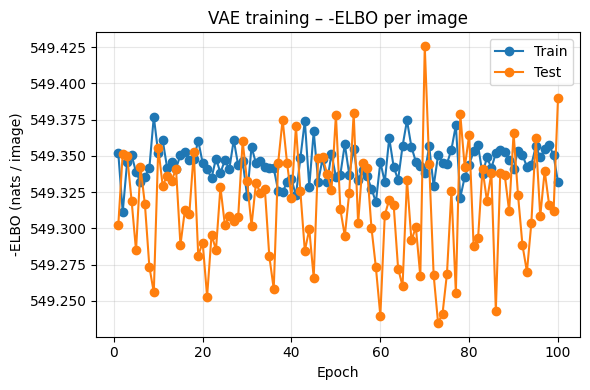

In [145]:
train_vae(vae1, train_loader, test_loader, opt1, 50, epochs=100, device=DEVICE, print_every=1)

Training of VAE with z 500 and epochs 1000

Epoch 1/1000  Train -ELBO/img 160.08  Test -ELBO/img 142.44  Time: 11.3s
Epoch 2/1000  Train -ELBO/img 139.45  Test -ELBO/img 136.26  Time: 11.1s
Epoch 3/1000  Train -ELBO/img 131.91  Test -ELBO/img 126.89  Time: 11.1s
Epoch 4/1000  Train -ELBO/img 122.88  Test -ELBO/img 119.44  Time: 11.1s
Epoch 5/1000  Train -ELBO/img 117.31  Test -ELBO/img 115.54  Time: 11.0s
Epoch 6/1000  Train -ELBO/img 114.64  Test -ELBO/img 113.46  Time: 10.9s
Epoch 7/1000  Train -ELBO/img 112.82  Test -ELBO/img 112.14  Time: 10.9s
Epoch 8/1000  Train -ELBO/img 111.44  Test -ELBO/img 111.33  Time: 10.7s
Epoch 9/1000  Train -ELBO/img 110.50  Test -ELBO/img 110.46  Time: 10.6s
Epoch 10/1000  Train -ELBO/img 109.70  Test -ELBO/img 109.67  Time: 10.6s
Epoch 11/1000  Train -ELBO/img 109.15  Test -ELBO/img 108.98  Time: 10.5s
Epoch 12/1000  Train -ELBO/img 108.63  Test -ELBO/img 108.50  Time: 10.5s
Epoch 13/1000  Train -ELBO/img 108.18  Test -ELBO/img 108.39  Time: 10.5s
Epoch 14/1000  Train -ELBO/img 107.84  Test -EL

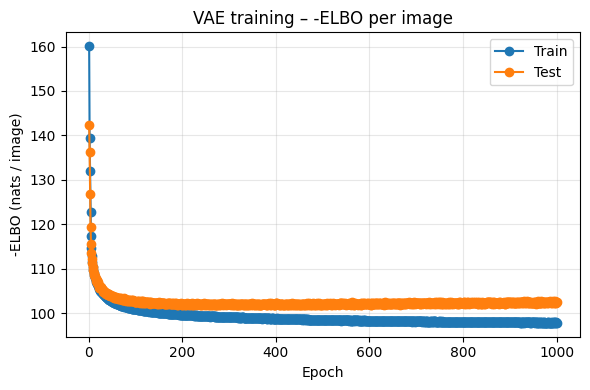

In [146]:
train_vae(vae2, train_loader, test_loader, opt2, 500, epochs=1000, device=DEVICE, print_every=1)

In [147]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


mnist = datasets.MNIST(root="data", train=False, download=True, transform=transforms.ToTensor())
loader = DataLoader(mnist, batch_size=256, shuffle=False)



In [152]:
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def display_latent_seration(loader, vae):
    
    
    all_mu, all_y = [], []
    device=DEVICE
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = vae(x)
            _, mu, _ = out
            all_mu.append(mu.cpu())
            all_y.append(y)

            
                

    all_mu = torch.cat(all_mu).numpy()   # [N, z]
    all_y  = torch.cat(all_y).numpy()    # [N]
   
    pca = PCA(n_components=2)
    lat2d = pca.fit_transform(all_mu)
   
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(lat2d[:, 0], lat2d[:, 1], c=all_y, cmap="tab10", s=8)
    cbar = plt.colorbar(sc, ticks=range(10))
    cbar.set_label("Digit")
    plt.title("MNIST latent space (PCA → 2D)")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()



Latent Representation of z = 500 and 100 epochs 

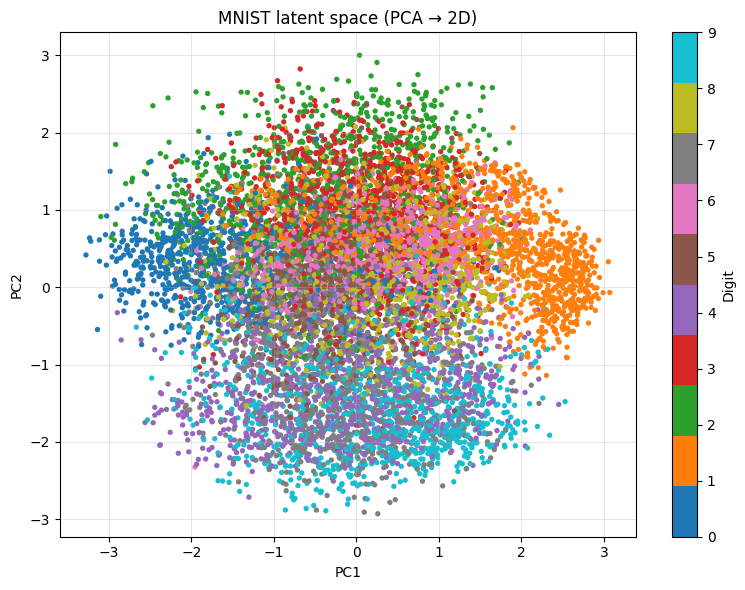

In [153]:
display_latent_seration(loader, vae)

Latent Representation of z = 50 and 100 epochs 

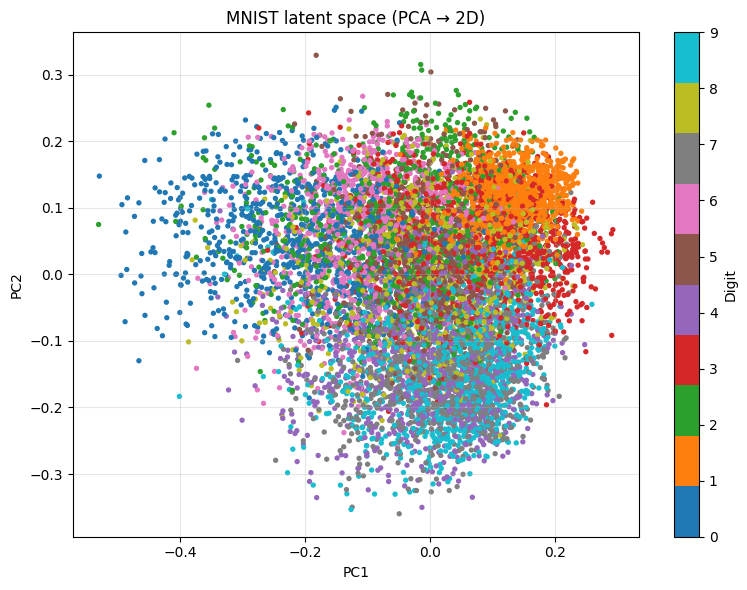

In [154]:
display_latent_seration(loader, vae1)

Latent Representation of z = 500 and 1000 epochs 

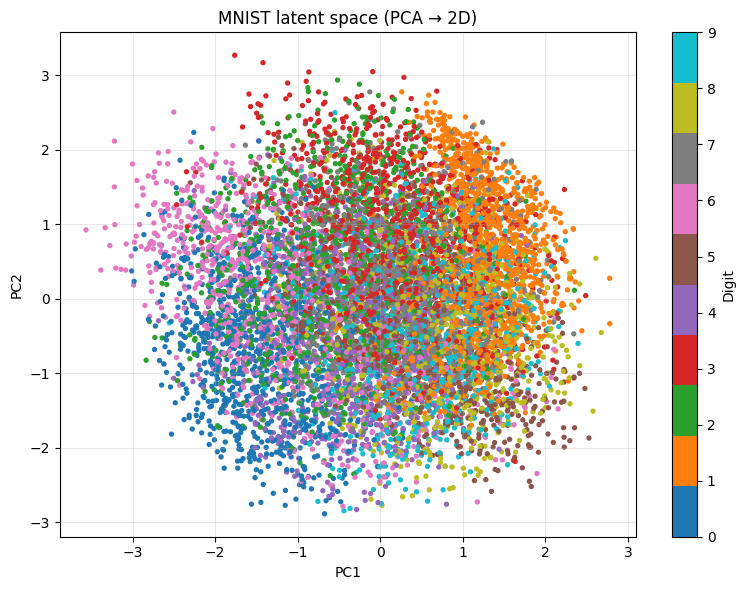

In [155]:
display_latent_seration(loader, vae2)

Results Display

In [ ]:
def to_img(tensor):
    if tensor.dim() == 2 and tensor.size(1) == 784:
        tensor = tensor.view(-1, 1, 28, 28)
    elif tensor.dim() == 3 and tensor.size(1) == 28 and tensor.size(2) == 28:
        tensor = tensor.unsqueeze(1)
    return tensor

In [ ]:
batch_imgs, batch_labels = next(iter(loader))
batch_imgs = batch_imgs.to(DEVICE)
num_pairs = 10

with torch.no_grad():
    output_0 = vae(batch_imgs)
    result_0 = output_0[0] if isinstance(output_0, (tuple, list)) else output_0

    output_1 = vae1(batch_imgs)
    result_1 = output_1[0] if isinstance(output_1, (tuple, list)) else output_1

    output_2 = vae2(batch_imgs)
    result_2 = output_2[0] if isinstance(output_2, (tuple, list)) else output_2



result_0 = to_img(result_0).cpu()
result_1 = to_img(result_1).cpu()
result_2 = to_img(result_2).cpu()
inputs_cpu = batch_imgs.cpu()

rows = 4
cols = num_pairs
fig, result_axes = plt.subplots(rows, cols, figsize=(cols * 1.3, rows * 1.3))

for idx in range(num_pairs):
    
    result_axes[0, idx].imshow(inputs_cpu[idx].squeeze(), cmap="gray")
    result_axes[0, idx].axis("off")

    
    result_axes[1, idx].imshow(result_0[idx].squeeze(), cmap="gray")
    result_axes[1, idx].axis("off")

    
    result_axes[2, idx].imshow(result_1[idx].squeeze(), cmap="gray")
    result_axes[2, idx].axis("off")

    
    result_axes[3, idx].imshow(result_2[idx].squeeze(), cmap="gray")
    result_axes[3, idx].axis("off")

result_axes[0, 0].set_title("Input", fontsize=10)
result_axes[1, 0].set_title("VAE (z=500, 100 ep)", fontsize=10, pad=10)
result_axes[2, 0].set_title("VAE1 (z=50, 100 ep)", fontsize=10, pad=10)
result_axes[3, 0].set_title("VAE2 (z=500, 1000 ep)", fontsize=10, pad=10)

plt.tight_layout()
plt.show()